In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
from itertools import groupby
import numpy as np
import cv2
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
from glob import glob
from multiprocessing import Pool
import matplotlib.pyplot as plt
# import cupy as cp
import ast
from pathlib import Path
import pickle5 as pickle
import torch

import shutil
import sys
sys.path.append("../src/")
sys.path.append("../raft_pytorch/")

import util

from joblib import Parallel, delayed

from IPython.display import display, HTML
from sahi.model import Yolov5DetectionModel
from sahi.utils.cv import read_image
from sahi.utils.file import download_from_url
from sahi.predict import get_prediction, get_sliced_prediction, predict
from ensemble_boxes import weighted_boxes_fusion

import albumentations as A

from IPython.display import Image
from matplotlib import animation, rc
rc('animation', html='jshtml')

In [3]:
from IPython.display import Image
from PIL import Image as Img
import subprocess
#This code I found in: https://www.kaggle.com/bamps53/create-annotated-video Thank you for sharing.
out_dir = "/home/vincent/Kaggle/data/tensorflow-great-barrier-reef/video_check/"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

def load_image(image_dir):
    assert os.path.exists(image_dir), f'{image_dir} does not exist.'
    img = cv2.imread(str(image_dir))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def load_image_with_annotations(image_dir, annotations):
    img = load_image(image_dir)
    if len(annotations) > 0:
        for ann in annotations:
            cv2.rectangle(img, (ann['x'], ann['y']),
                (ann['x'] + ann['width'], ann['y'] + ann['height']),
                (0, 255, 0), thickness=2,)
    return img

def show_prediction(img, bboxes, scores, show = True):
    colors = [(0, 0, 255)]

    obj_names = ["s"]

    for box, score in zip(bboxes, scores):
        cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3])), (255,0,0), 2)
        cv2.putText(img, f'{score:.2f}', (int(box[0]), int(box[1])-3), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2, cv2.LINE_AA)
    if show:
        img = Img.fromarray(img).resize((1280, 720))
    return img

def make_video(df, video_id, sequence_id, pred_col, out_dir, best_conf, name=None, s_f=None, e_f=None):
    fps = 15
    width = 1280
    height = 720
    if name is None:
        name = "video"
    
    save_path = f'{out_dir}/{name}.mp4'
    tmp_path =  f'{out_dir}/tmp-{name}.mp4'
    output_video = cv2.VideoWriter(tmp_path, cv2.VideoWriter_fourcc(*"MP4V"), fps, (width, height),)
    
    # I just generate ony part of video
    if video_id is not None and sequence_id is not None:
        query = 'video_id == {} and sequence == {}'.format(video_id, sequence_id)
        if s_f is not None:
            query = query + 'and video_frame >= {} and video_frame <= {}'.format(s_f, e_f)
        print(query)
        video_df = df.query(query)
    else:
        video_df = df
    print(video_df.shape)
    for _, row in tqdm(video_df.iterrows(), total=len(video_df)):
        video_id = row.video_id
        video_frame = row.video_frame
        annotations = row.annotations
        img_file = row.image_path
        img = load_image_with_annotations(img_file, annotations)
        preds = row[pred_col]
        best_conf = 0
        bboxes = [preds[i][1:] for i in range(len(preds)) if preds[i][0] >= best_conf]
        confis = [preds[i][0] for i in range(len(preds)) if preds[i][0] >= best_conf]        
        img = show_prediction(img, bboxes, confis, show=False)
        cv2.putText(img, f'{video_id}-{video_frame}', (10,70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        output_video.write(img)
    
    output_video.release()

    if os.path.exists(save_path):
        os.remove(save_path)
    subprocess.run(
        ["ffmpeg", "-i", tmp_path, "-crf", "18", "-preset", "veryfast", "-vcodec", "libx264", save_path]
    )
    os.remove(tmp_path)
from base64 import b64encode
def play(filename):
    html = ''
    video = open(filename,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=1280 controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [4]:
df_GT = pd.read_csv( "../input/train_with_added_GT.csv")
df_GT['new_added_pred_LB'] = df_GT['new_added_pred_LB'].apply(ast.literal_eval)
GT_sizes = np.concatenate(df_GT['new_added_pred_LB'].apply(lambda x: [p['width'] * p['height'] for p in x ]))
#GT_sizes

In [5]:
np.quantile(GT_sizes / (1280 * 720), 0.8)

0.001400607638888889

# Load Data

In [6]:
use_GT = True
cv_scheme = 'v2'
INPUT_DIR = Path("../../data/tensorflow-great-barrier-reef/")
df = pd.read_csv( "../input/train_with_added_GT.csv")
if cv_scheme == "video_id":
    df['fold'] = df['video_id']
elif cv_scheme == "v2":
    folds = util.load_pickle("../input/fold_test_2.pkl")
    df["fold"] = df["sequence"].apply(lambda x: folds[x])
    
highFP_df = pd.read_csv('../input/df_highFPNoBB.csv')
df = pd.merge(df, highFP_df[['video_id',"video_frame","highFBNoBB"]], on=["video_id","video_frame"], how='left')
df["highFBNoBB"].fillna(False, inplace=True)

data_param = {'root_dir':INPUT_DIR,'label_dir':INPUT_DIR / "labels"}
df = df.progress_apply(lambda x: util.get_path(x, data_param, infer=True), axis=1)
df['annotations_GT'] = df['new_annotations_LB'].progress_apply(lambda x: ast.literal_eval(x))
df['annotations'] = df['annotations'].progress_apply(lambda x: ast.literal_eval(x))

df["real_bbox"] = df["annotations"].apply(lambda annots: [list(annot.values()) for annot in annots])
df["real_bbox_GT"] = df["annotations_GT"].apply(lambda annots: [list(annot.values()) for annot in annots])
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
df['num_bbox_GT'] = df['annotations_GT'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

  0%|          | 0/23501 [00:00<?, ?it/s]

No BBox: 79.07% | With BBox: 20.93%


In [7]:
df.groupby("video_id")['num_bbox'].sum()

video_id
0    3065
1    6384
2    2449
Name: num_bbox, dtype: int64

In [8]:
def add_df(name, from_col=None, to_col=None):
    path = "./oof_pred/" + name
    df_2 = util.load_pickle(path)
    if from_col is not None:
        df_2 = df_2.rename(columns = {from_col:to_col})
    for col in df_2.columns:
        if col not in df.columns:
            new_col = col
            if "_fold1" not in new_col and "pred" in new_col:
                new_col = new_col + "_fold1"
            df.loc[df.query('fold==1').index,new_col] = df_2.loc[df_2.query('fold==1').index,col].values
#add_df("pred_0207_yolov5m6_B_LS02_newGT_CV_video1.pkl")
add_df("pred_best_s6_3600_GT.pkl")
#add_df("img6000pred_0209_m6_B_LS02_newLGBT.pkl", "pred_0209_m6_B_LS02_newLGBT","pred_0209_m6_B_LS02_newLGBT_img6000")
add_df("pred_0209_m6_B_LS02_newLGBT.pkl")
#add_df("best_s6_3600_GT.pkl")

add_df("pred_0207_m6_B_LS02_newGT_clahe.pkl")
#add_df("pred_0208_s6_B_LS02_newGT_clahe.pkl")
#add_df("pred_0208_s6_B_LS02_newGT_clahe.pkl")
add_df('pred_0208_m_TPH_1900_B_LS02_newGT.pkl')            
add_df('pred_0209_m6_B_LS02_LGBT_newP.pkl')            
add_df('pred_oof_pred_r27-0210-yolov5m6-2400_fold1_img3120.pkl')
add_df('pred_0209_s6_B_LS02_newGT_img4096_valid.pkl')
add_df('pred_0211_m6_B_LS02_LGBT_newP_clahe.pkl')
add_df('pred_0211_crcnn_1600.pkl')
add_df("pred_oof_pred_r27_m6_add_gt_fold1_img3120.pkl")
#add_df('pred_CV3_0128.pkl')
#add_df('pred_CV3_s1800_0129.pkl')
# add_df('pred_CV3_s1800_e11_0129.pkl')
#add_df('pred_CV3_s1280_clahe_0129.pkl')
#add_df('pred_CV3_s3600_e11_0129.pkl', 'pred_0129_yolov5l_v3_highFP_1800_e11_fold1', 'pred_0129_yolov5l_v3_highFP_3600_e11_fold1')
#add_df('pred_CV3_s1800_clahe_0129.pkl')
#add_df('pred_CV3_s2700_clahe_0129.pkl', 'pred_0129_yolov5l_v3_1800_clahe_fold1', 'pred_0129_yolov5l_v3_2700_clahe_fold1')
# add_df('pred_CV3_m6_s2300_clahe_0130.pkl')
# add_df('pred_CV3_0130_exps.pkl')
# add_df('pred_CV3_0131_exps.pkl')

#add_df('pred_CV3_0203_sliced.pkl')
#add_df('pred_0130_yolov5m6_noClahe_2300_IOU07.pkl', 'pred_0130_yolov5m6_noClahe_2300_fold1', 'pred_0130_yolov5m6_noClahe_2300_IOU07_fold1')
#add_df('pred_CV3_0204_x6_1320.pkl')
# add_df('pred_0205_m_TPH_1900_B.pkl')
#add_df('pred_0205_yolov5s6_HA.pkl')
# add_df('pred_0205_yolov5m6_B.pkl')
# add_df('pred_0204_yolov5s6_B.pkl')
# add_df('pred_0205_m_P7_2300_B.pkl')
# add_df('pred_0205_m_TPH_1900_B_LR1e3.pkl')
# add_df('pred_0205_yolov5m6_B_LS02.pkl')
# add_df('pred_oof_pred_r22-0206-yolov5x6-1920_fold1_img2496.pkl')
# add_df('pred_0206_yolov5m6_B_LS01.pkl')
# add_df('pred_0206_yolov5m6_B_LS06.pkl')
# add_df('pred_0207_yolov5s6_B_LS02_newGT.pkl')
# add_df('pred_0207_yolov5m6_B_LS02_newGT.pkl')
# add_df('pred_0207_yolov5m6_B_LS02_newGT_clahe.pkl')
# add_df('pred_0207_m_TPH_1900_B_newGT.pkl')



In [9]:
df_oof = df.query("fold == 1").copy()

In [10]:
def get_predict(label_dir, image_id, conf_thr=0.01):
    label_path = label_dir + image_id + '.txt'
    #print(label_path)
    try:
        with open(label_path, 'r') as f:
            pred_string = f.read().splitlines()
        pred_bboxes = []
        for pred in pred_string:
            bbox = list(map(lambda i: float(i), pred.split(' ')))
            pred_bboxes.append(bbox[1:])
    except:
        # print(label_path)
        return [], []
        
    if len(pred_bboxes) == 0:
        return [], []
    pred_bboxes = np.array(pred_bboxes)
    #print(pred_bboxes[0])
    pred_bboxes[:, [0, 2]] = pred_bboxes[:, [0, 2]] * 1280
    pred_bboxes[:, [1, 3]] = pred_bboxes[:, [1, 3]] * 720
    pred_bboxes[:, [0, 1]] = pred_bboxes[:, [0, 1]] - pred_bboxes[:, [2, 3]] / 2
    pred_bboxes = pred_bboxes[pred_bboxes[:, 4] > conf_thr]
    return pred_bboxes[:, :4], pred_bboxes[:, 4]

def get_pred(label_dir, video_id, video_frame):
    bbox, conf = get_predict(label_dir, "{}-{}".format(video_id, video_frame))
    if len(bbox) > 0:
        bbox = bbox.tolist()
        conf = conf.tolist()
    return [[conf[i]] + bbox[i] for i in range(len(conf))]

In [11]:
df_oof['pred_GT_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT_4680/", x['video_id'], x['video_frame']), axis=1)
df_oof['pred_GT2_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT2_4680/", x['video_id'], x['video_frame']), axis=1)
df_oof['pred_GT3_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT3_4680/", x['video_id'], x['video_frame']), axis=1)

df_oof['pred_GT_transfer_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT_transfer_4680/", x['video_id'], x['video_frame']), axis=1)
df_oof['pred_GT2_transfer_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT2_transfer_4680/", x['video_id'], x['video_frame']), axis=1)
df_oof['pred_GT3_transfer_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/weights_and_predictions/labels_GT3_transfer_4680/", x['video_id'], x['video_frame']), axis=1)
#df_oof['pred_GT_4680_fold1'] = df_oof.apply(lambda x:  get_pred("./oof_pred/labels_GT_4680/", x['video_id'], x['video_frame']), axis=1)

## mmdetection pred

In [12]:
mm_model_versions = []
for mm_v in mm_model_versions:
    pred = util.load_pickle(f"../output/{mm_v}/test_result.pkl")
    pred_new = []
    for p in pred:
        p_sub = p[0]
        p_sub = p_sub[:,[4,0,1,2,3]]
        p_sub[:,3:] = p_sub[:,3:] - p_sub[:,1:3]
        pred_new.append(p_sub)
    df_oof["pred_"+mm_v + "_fold1"] = pred_new

## All Model

In [13]:
model_versions = ["_".join(col.split("_")[1:-1]) for col in df_oof.columns if "_fold1" in col]
model_versions

['best_s6_3600_GT',
 '0209_m6_B_LS02_newLGBT',
 '0207_m6_B_LS02_newGT_clahe',
 '0208_s6_B_LS02_newGT',
 '0208_m_TPH_1900_B_LS02_newGT',
 '0209_m6_B_LS02_LGBT_newP',
 'r27-0210-yolov5m6-2400',
 '0209_s6_B_LS02_newGT_img4096_valid',
 '0211_m6_B_LS02_LGBT_newP_clahe',
 '0211_crcnn_1600',
 'r27_m6_add_gt',
 'GT_4680',
 'GT2_4680',
 'GT3_4680',
 'GT_transfer_4680',
 'GT2_transfer_4680',
 'GT3_transfer_4680']

# Pick Conf Thresh

In [14]:
gt_bboxs_list_GT = []
gt_bboxs_list = []
for index in df_oof.index:
    gt_bboxs_list.append(np.array(df_oof.loc[index, "real_bbox"]))
    gt_bboxs_list_GT.append(np.array(df_oof.loc[index, "real_bbox_GT"]))

In [16]:
#conf_ths = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
#conf_ths = np.arange(5, 20)
#conf_ths = np.arange(35, 45)
conf_ths = [25]
#conf_ths = np.arange(20, 40)
#conf_ths = np.arange(30, 40)
#conf_ths = [30]

#conf_ths = [12, 16, 18, 20, 22, 24]
#conf_ths = [6, 8, 10, 12, 14]
#conf_ths = [30, 32, 35, 38, 45, 50, 55]
iou_ths = np.arange(0.3, 0.85, 0.05)
fold = 1
check_models = ['GT_4680','GT2_4680','GT3_4680', 'GT_transfer_4680', 'GT2_transfer_4680', 'GT3_transfer_4680']
for model_version in model_versions:
    if not model_version in check_models:
        continue
    pred_col = "pred_" + model_version + f"_fold{fold}"
    for conf_th in conf_ths:
        conf_th /= 100
        prd_bboxs_list = []
        for index in df_oof.index:
            prd_bboxs = df_oof.loc[index, pred_col]
            prd_bboxs = [p for p in prd_bboxs if p[0] >= conf_th]
            prd_bboxs_list.append(np.array(prd_bboxs))
        f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
        print("model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, conf_th, f2_dict['f2'], f2_dict['P'], f2_dict['R']))

model GT_4680, conf_th 0.20, f2 0.690, precision 0.556, recall 0.734
model GT_4680, conf_th 0.21, f2 0.693, precision 0.570, recall 0.732
model GT_4680, conf_th 0.22, f2 0.695, precision 0.579, recall 0.732
model GT_4680, conf_th 0.23, f2 0.698, precision 0.591, recall 0.731
model GT_4680, conf_th 0.24, f2 0.701, precision 0.601, recall 0.731
model GT_4680, conf_th 0.25, f2 0.701, precision 0.612, recall 0.728
model GT_4680, conf_th 0.26, f2 0.702, precision 0.621, recall 0.726
model GT_4680, conf_th 0.27, f2 0.703, precision 0.628, recall 0.725
model GT_4680, conf_th 0.28, f2 0.702, precision 0.633, recall 0.721
model GT_4680, conf_th 0.29, f2 0.703, precision 0.641, recall 0.721
model GT_4680, conf_th 0.30, f2 0.702, precision 0.648, recall 0.717
model GT_4680, conf_th 0.31, f2 0.702, precision 0.655, recall 0.715
model GT_4680, conf_th 0.32, f2 0.703, precision 0.664, recall 0.714
model GT_4680, conf_th 0.33, f2 0.703, precision 0.671, recall 0.711
model GT_4680, conf_th 0.34, f2 0.

model GT3_transfer_4680, conf_th 0.32, f2 0.716, precision 0.658, recall 0.732
model GT3_transfer_4680, conf_th 0.33, f2 0.717, precision 0.662, recall 0.732
model GT3_transfer_4680, conf_th 0.34, f2 0.713, precision 0.667, recall 0.726
model GT3_transfer_4680, conf_th 0.35, f2 0.712, precision 0.673, recall 0.722
model GT3_transfer_4680, conf_th 0.36, f2 0.710, precision 0.677, recall 0.719
model GT3_transfer_4680, conf_th 0.37, f2 0.708, precision 0.682, recall 0.715
model GT3_transfer_4680, conf_th 0.38, f2 0.706, precision 0.688, recall 0.711
model GT3_transfer_4680, conf_th 0.39, f2 0.705, precision 0.691, recall 0.709


In [17]:
best_conf_dict = {
    '0209_m6_B_LS02_newLGBT':0.1,
    "0209_m6_B_LS02_newLGBT_img6000":0.15,
    '0207_m6_B_LS02_newGT_clahe': 0.25,
    '0208_s6_B_LS02_newGT': 0.30,
    '0208_s6_B_LS02_newGT_clahe': 0.30,
    '0208_m_TPH_1900_B_LS02_newGT':0.30,
    '0207_yolov5m6_B_LS02_newGT_CV_video1': 0.18,
    'best_s6_3600_GT':0.3, 
    '0209_m6_B_LS02_LGBT_newP': 0.20,
    'r27-0210-yolov5m6-2400': 0.27,
    '0209_s6_B_LS02_newGT_img4096_valid': 0.35,
    'GT_4680': 0.30,
    'GT2_4680': 0.30,
    'GT3_4680': 0.30, 
    'GT_transfer_4680': 0.30, 
    'GT2_transfer_4680': 0.21, 
    'GT3_transfer_4680': 0.33,
    'GT3_4680': 0.33,
    'GT_4680': 0.33,
    
    '0211_crcnn_1600':0.42,
    '0211_m6_B_LS02_LGBT_newP_clahe':0.25,
    '0212_crcnn_1600_base7':0.4,
    '0212_crcnn_1600_e20':0.4,
    'r27_m6_add_gt': 0.22,
    
    '0128_yolov5l_v3': 0.25, #0.649
    "0128_yolov5l_v3_highFP": 0.25, #642
    "0129_yolov5l_v3_highFP_1800": 0.25, #645
    "0129_yolov5l_v3_highFP_1800_e11": 0.16,
    "0129_yolov5l_v3_highFP_clahe": 0.19,
    '0129_yolov5l_v3_highFP_3600_e11': 0.25,
    '0129_yolov5l_v3_1800_clahe': 0.15,
    '0129_yolov5l_v3_2700_clahe': 0.2,
    '0130_yolov5m6_2300': 0.27, # 660
    '0130_yolov5s6_3100': 0.31, # 646
    "0130_yolov5m6_noHighFP_2300": .40, # 655
    "0130_yolov5m6_noClahe_2300": .23, # 678
    "0130_yolov5m6_2300_sheep": .11, #669
    "0131_yolov5s6_3100_noClahe_sheep_whole": .29, #673
    '0131_frcnn_1600': 0.28,
    '0201_frcnn_1600_highFP' : 0.40,
    '0202_frcnn_1600_highFP_e8': 0.34, #621
    '0202_vf_1700_highFP_e11': 0.4,
    '0203_m6_1200_sliced_S720_ma025_lr5e4': 0.44, #666
    '0203_m6_1000_sliced_S400x711_ma025': 0.38,
    '0203_m6_1200_sliced_S720_ma025_lr5e4_AUG':0.53,
    '0203_yolov5x6_1320':0.31, 
    '0205_m_TPH_1900_B':0.27, # 660
    "0205_yolov5s6_HA":0.21, #666
    '0205_yolov5m6_B': 0.17, #688
    '0204_yolov5s6_B': 0.20, #683
    '0205_yolov5s6_MA': 0.23, #664
    '0205_m_P7_2300_B': 0.34, #659
    '0205_m_TPH_1900_B_LR1e3': 0.36, # 678
    '0205_yolov5m6_B_LS02': 0.3, # 687
    'r22-0206-yolov5x6-1920':0.2,
    "0206_yolov5m6_B_LS01": 0.15, # 671
    "0206_yolov5m6_B_LS06": 0.20, # 669
    '0207_yolov5s6_B_LS02_newGT':0.20, # 663
    '0207_yolov5m6_B_LS02_newGT':0.38, # 680,
    '0207_yolov5m6_B_LS02_newGT_clahe':0.33, # 682
    '0207_m_TPH_1900_B_newGT':0.21,#661
} 

In [18]:
pd.set_option('display.max_columns', 40)
f_cols = ["f2"] + ["f2_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]
P_cols = ["P"] + ["P_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]
R_cols = ["R"] + ["R_" + str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]

In [19]:
df_perf_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in model_versions}
fold = 1
f2_score = {}
P_score = {}
R_score = {}
f2_specific_keys = ['f2_0.3', 'f2_0.35', 'f2_0.4', 'f2_0.45', 'f2_0.5', 'f2_0.55', 'f2_0.6', 'f2_0.65', 'f2_0.7', 'f2_0.75', 'f2_0.8']
f2_specific_score = {k:{} for k in f2_specific_keys}
for model_version in model_versions:
    pred_col = "pred_" + model_version + f"_fold{fold}"
    conf_th = best_conf_dict[model_version]
    prd_bboxs_list = []
    for index in df_oof.index:
        prd_bboxs = df_oof.loc[index, pred_col]
        prd_bboxs = [p for p in prd_bboxs if p[0] >= conf_th]
        prd_bboxs_list.append(np.array(prd_bboxs))
    f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_list, verbose=False)    
    df_perf_dict[model_version].loc["f2",:] = [f2_dict[col] for col in f_cols]
    df_perf_dict[model_version].loc["P",:] = [f2_dict[col] for col in P_cols]
    df_perf_dict[model_version].loc["R",:] = [f2_dict[col] for col in R_cols]
    f2_score[model_version] = f2_dict['f2']
    P_score[model_version] = f2_dict['P']
    R_score[model_version] = f2_dict['R']
    for k in f2_specific_keys:
        f2_specific_score[k][model_version] = f2_dict[k]
    print("model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, conf_th, f2_dict['f2'], f2_dict['P'], f2_dict['R']))
    display(df_perf_dict[model_version].astype(float).style.format("{:.3f}").background_gradient(axis=1))

model best_s6_3600_GT, conf_th 0.30, f2 0.702, precision 0.636, recall 0.720


model 0209_m6_B_LS02_newLGBT, conf_th 0.10, f2 0.691, precision 0.648, recall 0.702


model 0207_m6_B_LS02_newGT_clahe, conf_th 0.25, f2 0.695, precision 0.667, recall 0.703


model 0208_s6_B_LS02_newGT, conf_th 0.30, f2 0.666, precision 0.636, recall 0.674


model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.30, f2 0.640, precision 0.621, recall 0.644


model 0209_m6_B_LS02_LGBT_newP, conf_th 0.20, f2 0.703, precision 0.683, recall 0.708


model r27-0210-yolov5m6-2400, conf_th 0.27, f2 0.704, precision 0.671, recall 0.713


model 0209_s6_B_LS02_newGT_img4096_valid, conf_th 0.35, f2 0.692, precision 0.732, recall 0.682


model 0211_m6_B_LS02_LGBT_newP_clahe, conf_th 0.25, f2 0.697, precision 0.649, recall 0.710


model 0211_crcnn_1600, conf_th 0.42, f2 0.633, precision 0.668, recall 0.625


model r27_m6_add_gt, conf_th 0.22, f2 0.700, precision 0.667, recall 0.709


model GT_4680, conf_th 0.33, f2 0.703, precision 0.671, recall 0.711


model GT2_4680, conf_th 0.30, f2 0.732, precision 0.704, recall 0.739


model GT3_4680, conf_th 0.33, f2 0.719, precision 0.697, recall 0.725


model GT_transfer_4680, conf_th 0.30, f2 0.717, precision 0.669, recall 0.731


model GT2_transfer_4680, conf_th 0.21, f2 0.710, precision 0.631, recall 0.733


model GT3_transfer_4680, conf_th 0.33, f2 0.717, precision 0.662, recall 0.732


In [20]:
f2_score_df = pd.DataFrame.from_dict(f2_score,orient='index',columns=["f2"])
P_score_df = pd.DataFrame.from_dict(P_score,orient='index',columns=["P"])
R_score_df = pd.DataFrame.from_dict(R_score,orient='index',columns=["R"])
f2_s_df = []
for k in f2_specific_keys:
    f2_s_df.append(pd.DataFrame.from_dict(f2_specific_score[k],orient='index',columns=[k]))
score_df = pd.concat([f2_score_df, P_score_df, R_score_df] + f2_s_df, axis=1)

score_df.style.format("{:.3f}").background_gradient(axis=0)

# Tracking

In [21]:
# from raft.core.raft import RAFT
# #from raft.core.utils import flow_viz
# from raft.core.utils.utils import InputPadder
# from raft.config import RAFTConfig

# raft_config = RAFTConfig(
#     dropout=0,
#     alternate_corr=False,
#     small=False,
#     mixed_precision=False
# )

# raft_model = RAFT(raft_config)

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'device: {device}')

# weights_path = '../raft_pytorch/raft-sintel.pth'
# # weights_path = '/kaggle/input/raft-pytorch/raft-things.pth'

# ckpt = torch.load(weights_path, map_location=device)
# raft_model.to(device)
# raft_model.load_state_dict(ckpt)

# SMALL_RATE = 0.25 # image scaling rate 
# STD_TH = 12 # threshold of std of optical flow

In [22]:
from norfair import Detection, Tracker

# Helper to convert bbox in format [x_min, y_min, x_max, y_max, score] to norfair.Detection class
def to_norfair(detects, frame_id):
    result = []
    for x_min, y_min, x_max, y_max, score in detects:
        xc, yc = (x_min + x_max) / 2, (y_min + y_max) / 2
        w, h = x_max - x_min, y_max - y_min
        result.append(Detection(points=np.array([xc, yc]), scores=np.array([score]), data=np.array([w, h, frame_id])))
        
    return result

def euclidean_distance(detection, tracked_object):
    return np.linalg.norm(detection.points - tracked_object.estimate)

def tracking_function(tracker, frame_id, bboxes, scores, best_conf, num_prev_bbox=None):
    
    detects = []
    predictions = []
    
    if len(scores)>0:
        for i in range(len(bboxes)):
            # remember to check
            if scores[i] <= best_conf:
                continue
            box = bboxes[i]
            score = scores[i]
            x_min = int(box[0])
            y_min = int(box[1])
            bbox_width = int(box[2])
            bbox_height = int(box[3])
            detects.append([x_min, y_min, x_min+bbox_width, y_min+bbox_height, score])
            predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
#             print(predictions[:-1])
    # Update tracks using detects from current frame
    tracked_objects = tracker.update(detections=to_norfair(detects, frame_id))
    #print("frame_id {}, number of notrack pred {}, number of tracked_objects {}, their frame_id {}, box x, y {}".format(frame_id, len(bboxes), len(tracked_objects),
    #                                                                                                       [o.last_detection.data[-1] for o in tracked_objects], 
    #                                                                                                        [o.estimate[0] for o in tracked_objects]))
    to_add_preds = []
    for tobj in tracked_objects:
        bbox_width, bbox_height, last_detected_frame_id = tobj.last_detection.data
        if last_detected_frame_id == frame_id:  # Skip objects that were detected on current frame
            continue
        xc, yc = tobj.estimate[0]
        x_min, y_min = int(round(xc - bbox_width / 2)), int(round(yc - bbox_height / 2))

        #exclude those in the edge
        if (x_min + bbox_width >= 1279) or (y_min + bbox_height) >= 719 or (x_min <= 1) or (y_min <= 1):
            continue
        score = tobj.last_detection.scores[0]            
        track_pred = np.array([[x_min, y_min, bbox_width, bbox_height]])
        #to_add_preds.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
        predictions.append('{:.2f} {} {} {} {}'.format(score, x_min, y_min, bbox_width, bbox_height))
            
        
#     if (num_prev_bbox is None or (num_prev_bbox - len(predictions) + 1) >= len(to_add_preds)):
#         predictions.extend(to_add_preds)
        
    return predictions, tracker

In [23]:
df_perf_track_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in model_versions}
df_oof.sort_values(["video_id","video_frame"], inplace=True)
df_oof["track_pred"] = [[] for i in range(len(df_oof))]
f2_scores_track = {}
P_scores_track = {}
R_scores_track = {}
f2_specific_scores_track = {k:{} for k in f2_specific_keys}

for model_version in model_versions:
    BEST_CONF = best_conf_dict[model_version]
    pred_col = "pred_" + model_version + f"_fold1"
    prd_bboxs_tracking_list = []
    frame_id = 0
    tracker = Tracker(
        distance_function=euclidean_distance, 
        distance_threshold=30,
        hit_inertia_min=0,
        hit_inertia_max=3,
        initialization_delay=2,
    )      
    num_prev_bbox = None
    for idx in df_oof.index:
        row = df_oof.loc[idx]
        prd_bboxs = row[pred_col]
        bboxes, confis = [p[1:] for p in prd_bboxs], [p[0] for p in prd_bboxs]    
        predictions,tracker = tracking_function(tracker, frame_id, bboxes, confis, BEST_CONF, num_prev_bbox)    
        prd_bboxs_tracking =  [[float(p) for p in pred.split(" ")] for pred in predictions]
        num_prev_bbox = len(bboxes)
        prd_bboxs_tracking_list.append(np.array(prd_bboxs_tracking))
        frame_id += 1        
        
    f2_dict = util.calc_f2_score(gt_bboxs_list, prd_bboxs_tracking_list, verbose=False) 
    f2_scores_track[model_version] = f2_dict['f2']
    P_scores_track[model_version] = f2_dict['P']
    R_scores_track[model_version] = f2_dict['R']
    for k in f2_specific_keys:
        f2_specific_scores_track[k][model_version] = f2_dict[k]
    
    
    df_perf_track_dict[model_version].loc["f2",:] = [f2_dict[col] for col in f_cols]
    df_perf_track_dict[model_version].loc["P",:] = [f2_dict[col] for col in P_cols]
    df_perf_track_dict[model_version].loc["R",:] = [f2_dict[col] for col in R_cols]
    df_oof[f'{model_version}_tps'] = f2_dict["tps"]
    df_oof[f'{model_version}_fps'] = f2_dict["fps"]
    df_oof[f'{model_version}_fns'] = f2_dict["fns"]
    print("Using Tracking new: model {}, conf_th {:.2f}, f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(model_version, BEST_CONF, f2_dict['f2'], f2_dict['P'], f2_dict['R']))
    display(df_perf_track_dict[model_version].astype(float).style.format("{:.3f}").background_gradient(axis=1))

Using Tracking new: model best_s6_3600_GT, conf_th 0.30, f2 0.714, precision 0.614, recall 0.744


Using Tracking new: model 0209_m6_B_LS02_newLGBT, conf_th 0.10, f2 0.708, precision 0.627, recall 0.732


Using Tracking new: model 0207_m6_B_LS02_newGT_clahe, conf_th 0.25, f2 0.702, precision 0.648, recall 0.717


Using Tracking new: model 0208_s6_B_LS02_newGT, conf_th 0.30, f2 0.684, precision 0.610, recall 0.705


Using Tracking new: model 0208_m_TPH_1900_B_LS02_newGT, conf_th 0.30, f2 0.655, precision 0.592, recall 0.673


Using Tracking new: model 0209_m6_B_LS02_LGBT_newP, conf_th 0.20, f2 0.714, precision 0.659, recall 0.730


Using Tracking new: model r27-0210-yolov5m6-2400, conf_th 0.27, f2 0.717, precision 0.643, recall 0.739


Using Tracking new: model 0209_s6_B_LS02_newGT_img4096_valid, conf_th 0.35, f2 0.709, precision 0.709, recall 0.709


Using Tracking new: model 0211_m6_B_LS02_LGBT_newP_clahe, conf_th 0.25, f2 0.704, precision 0.631, recall 0.725


Using Tracking new: model 0211_crcnn_1600, conf_th 0.42, f2 0.646, precision 0.649, recall 0.645


Using Tracking new: model r27_m6_add_gt, conf_th 0.22, f2 0.713, precision 0.645, recall 0.732


Using Tracking new: model GT_4680, conf_th 0.33, f2 0.714, precision 0.641, recall 0.735


Using Tracking new: model GT2_4680, conf_th 0.30, f2 0.741, precision 0.673, recall 0.760


Using Tracking new: model GT3_4680, conf_th 0.33, f2 0.733, precision 0.672, recall 0.750


Using Tracking new: model GT_transfer_4680, conf_th 0.30, f2 0.726, precision 0.644, recall 0.750


Using Tracking new: model GT2_transfer_4680, conf_th 0.21, f2 0.717, precision 0.605, recall 0.751


Using Tracking new: model GT3_transfer_4680, conf_th 0.33, f2 0.721, precision 0.630, recall 0.749


In [24]:
f2_score_t_df = pd.DataFrame.from_dict(f2_scores_track,orient='index',columns=["f2_t"])
P_score_t_df = pd.DataFrame.from_dict(P_scores_track,orient='index',columns=["P_t"])
R_score_t_df = pd.DataFrame.from_dict(R_scores_track,orient='index',columns=["R_t"])
f2_s_t_df = []
for k in f2_specific_keys:
    f2_s_t_df.append(pd.DataFrame.from_dict(f2_specific_scores_track[k],orient='index',columns=[k]))
score_df_t = pd.concat([f2_score_t_df, P_score_t_df, R_score_t_df] + f2_s_t_df, axis=1)
display(score_df.style.format("{:.3f}").background_gradient(axis=0))
display(score_df_t.style.format("{:.3f}").background_gradient(axis=0))

# Ensemble

In [25]:
sizes = np.concatenate(df['real_bbox'].apply(lambda x: [p[2]*p[3] for p in x]).values)
np.quantile(sizes, 0.33) / (1280 * 720)

0.0014322916666666666

In [26]:
# import collections
# wbf_models =['0209_m6_B_LS02_LGBT_newP', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0211_m6_B_LS02_LGBT_newP_clahe']
# pred_confs_dict = collections.defaultdict(list)
# for model_version in model_versions:
#     pred_col = "pred_" + model_version + f"_fold{fold}"
#     conf_th = best_conf_dict[model_version]    
#     for index in df_oof.index:
#         prd_bboxs = df_oof.loc[index, pred_col]
#         prd_confs = [p[0] for p in prd_bboxs if p[0] >= conf_th]
#         pred_confs_dict[model_version].extend(prd_confs)

# fig,axes = plt.subplots(1,2,figsize=(18,9))
# for model_version in model_versions:
#     axes[0].hist(pred_confs_dict[model_version], label=model_version,bins=100, alpha=0.5)
# axes[0].legend()

# for model_version in wbf_models:
#     axes[1].hist(pred_confs_dict[model_version], label=model_version,bins=100, alpha=0.5)
# axes[1].legend()

# plt.show()

In [27]:
# conf_stats = pd.DataFrame(columns=["mean","std","median", "min_n", "max_n"])
# for key in pred_confs_dict:
#     confs = np.array(pred_confs_dict[key])
#     norm_confs = (confs - np.mean(confs)) /  np.std(confs)
#     conf_stats.loc[key] = [np.mean(confs), np.std(confs), np.median(confs), np.min(norm_confs), np.max(norm_confs)]
# conf_stats.loc[wbf_models]

In [28]:
# def norm_conf(confs, mean, std, min_n, max_n):
#     confs = np.array(confs)
#     norm_confs = np.maximum(np.minimum(((confs - mean)/std - min_n) / (max_n - min_n), 1), 0.01)
#     return norm_confs.tolist()
# pred_confs_norm_dict = {}
# for key in pred_confs_dict:
#     pred_confs_norm_dict[key] = norm_conf(pred_confs_dict[key], 
#               conf_stats.loc[key, 'mean'],
#              conf_stats.loc[key, 'std'],
#              conf_stats.loc[key, 'min_n'],
#              conf_stats.loc[key, 'max_n'])
    
# fig,axes = plt.subplots(1,2,figsize=(18,9))
# for model_version in model_versions:
#     axes[0].hist(pred_confs_norm_dict[model_version], label=model_version,bins=100, alpha=0.5)
# axes[0].legend()

# for model_version in wbf_models:
#     axes[1].hist(pred_confs_norm_dict[model_version], label=model_version,bins=100, alpha=0.5)
# axes[1].legend()

# plt.show()

In [29]:
from image_similarity_measures.quality_metrics import rmse
from ensemble_boxes import weighted_boxes_fusion, nms, non_maximum_weighted, soft_nms

def modify_size(boxes, to01=True):
    if len(boxes) > 0:
        if to01:
            boxes[:,2:] = boxes[:,2:] + boxes[:,:2]
            boxes[:,0] = boxes[:,0] / 1279.
            boxes[:,1] = boxes[:,1] / 719.
            boxes[:,2] = boxes[:,2] / 1279.
            boxes[:,3] = boxes[:,3] / 719.
        else:
            boxes[:,0] = boxes[:,0] * 1279.
            boxes[:,1] = boxes[:,1] * 719.
            boxes[:,2] = boxes[:,2] * 1279.
            boxes[:,3] = boxes[:,3] * 719.
            boxes[:,2:] = boxes[:,2:] - boxes[:,:2]
        
    return boxes
    
def run_wbf(bboxes, confs, iou_thr=0.5, skip_box_thr=0.1, keep_small=False, small_thresh=0.001, verbose=False, weights=None):
    if len(bboxes) == 1:
        return bboxes[0], confs[0], []   
    else:
        for i in range(len(bboxes)):
            bboxes[i] = modify_size(bboxes[i], to01=True)    
    if keep_small:
        # for samll objects, we use NMS
        small_bboxes_num = 0
        small_bboxes = []
        small_confs = []
        for i in range(len(bboxes)):
            if len(bboxes[i]) != 0:
                sub_bboxes = bboxes[i].copy()
                sub_confs = confs[i].copy()
                sizes = (sub_bboxes[:,3] - sub_bboxes[:, 1]) * (sub_bboxes[:,2] - sub_bboxes[:, 0])
                small_place = np.where(sizes <= small_thresh)[0]
                
                sub_bboxes = sub_bboxes[small_place]
                sub_confs = np.array(sub_confs)[small_place].tolist()
                bboxes[i] = np.delete(bboxes[i], small_place, axis=0)
                confs[i] = np.delete(np.array(confs[i]), small_place, axis=0).tolist()
            else:
                sub_bboxes = np.empty((0,4))
                sub_confs = []
                
            small_bboxes.append(sub_bboxes)
            small_confs.append(sub_confs)            
            small_bboxes_num += len(sub_bboxes)
        small_labels = [np.ones(len(conf)) for conf in small_confs]
        if small_bboxes_num > 0:
            small_boxes, small_scores, small_labels = nms(small_bboxes, small_confs, small_labels, iou_thr=0.7)
        else:
            small_boxes, small_scores, small_labels = np.empty((0,4)), [], []
        if verbose:
            if len(small_boxes) > 0:
                print("Sm/all bboxes number {}, after NMS {}".format(small_bboxes_num, len(small_boxes) ))
        
    labels = [np.ones(len(conf)) for conf in confs]
    boxes, scores, labels = weighted_boxes_fusion(bboxes, confs, labels, iou_thr=iou_thr, skip_box_thr=0.001, allows_overflow=True, conf_type='avg', weights=weights)
    
    boxes = modify_size(boxes, to01=False)  
    boxes = [box for i,box in enumerate(boxes) if scores[i] >= skip_box_thr]
    scores = [conf for conf in scores if conf >= skip_box_thr]

    if keep_small:
        small_boxes = modify_size(small_boxes, to01=False)  
        boxes = boxes + [b for b in small_boxes]
        scores = scores + [s for s in small_scores]

    return boxes, scores, labels

In [31]:
display(score_df_t.style.format("{:.3f}").background_gradient(axis=0))

In [71]:
def init_tracker():
    tracker = Tracker(
        distance_function=euclidean_distance, 
        distance_threshold=30,
        hit_inertia_min=0,
        hit_inertia_max=3,
        initialization_delay=2,
    ) 
    return tracker
    
df_oof["wbf"] = None
df_oof['notrack_pred'] = None
df_oof['track_pred'] = None
write_track = False

normalize_score = False
keep_small = False
small_thresh = 0.001

iou_thr = 0.4
# 2 models
wbf_models =['GT2_4680', 'r27-0210-yolov5m6-2400']
# 4 models
#wbf_models =['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe']  

# 5 models + rcnn
#wbf_models =['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', "GT_transfer_4680", '0211_crcnn_1600']  
# 0211_crcnn_1600
# 7 models
#wbf_models =['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', "GT_transfer_4680", '0209_m6_B_LS02_LGBT_newP', 'r27_m6_add_gt']  
#wbf_models =['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', "GT_transfer_4680", '0209_m6_B_LS02_LGBT_newP', '0207_m6_B_LS02_newGT_clahe']  

df_perf_track_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in ['wbf']}
df_perf_notrack_dict = {model_version: pd.DataFrame(columns=["all"] + [str(round(th,3)) for th in np.arange(0.3, 0.85, 0.05)]).copy() for model_version in ['wbf']}
crcnn_bbox = []
crcnn_conf = []

num_prev_bbox = None
f2_score_t_df = pd.DataFrame(columns =['conf', 'th', 'f2'])
k = 0
for BEST_CONF in [0.01, 0.03, 0.05, 0.07, 0.09, 0.11]:
    for skip_box_thr in np.arange(1.4, 3.8, 0.2):
        skip_box_thr = skip_box_thr / 10
        prd_wbf_list = []
        prd_wbf_list_notrack = []
        frame_id = 0
        trackers = {j: init_tracker()  for j in range(len(model_versions))}

        prev_sim = None
        prev_image = None
        for i, idx in enumerate(df_oof.index):
            row = df_oof.loc[idx]
            bboxes_l = []
            confs_l = []                                    
            for j, model_version in enumerate(wbf_models):
                #BEST_CONF = best_conf_dict[model_version]
                #BEST_CONF = 0.075
                pred_col = "pred_" + model_version + f"_fold1"
                prd_bboxs = row[pred_col]
                prd_bboxs = [p for p in prd_bboxs if (p[0] >= BEST_CONF and p[3] * p[4] <= 15000)]
                bboxes, confis = [p[1:] for p in prd_bboxs], [p[0] for p in prd_bboxs]    
                if normalize_score:
                    confis =   norm_conf(confis, 
                                         conf_stats.loc[model_version, 'mean'],
                                         conf_stats.loc[model_version, 'std'],
                                         conf_stats.loc[model_version, 'min_n'],
                                         conf_stats.loc[model_version, 'max_n'])

                bboxes = np.array(bboxes,dtype=np.float64)
                predictions, tracker = tracking_function(trackers[j], frame_id, bboxes, confis, 0, num_prev_bbox)
                trackers[j] = tracker
                bboxes =  np.array([[float(p) for p in pred.split(" ")[1:]] for pred in predictions])
                confis =  np.array([float(pred.split(" ")[0]) for pred in predictions])

                if model_version in ['0211_crcnn_1600']:
                    crcnn_bbox = bboxes
                    crcnn_conf = confis # [c * 0.8 for c in confis]
                else:
                    bboxes_l.append(bboxes)
                    confs_l.append(confis)

            wbf_boxes, wbf_confs, _ = run_wbf(bboxes_l, confs_l, iou_thr, skip_box_thr, keep_small, small_thresh, verbose=False)
            if len(crcnn_bbox) > 0 and len(wbf_boxes) > 0:
                keep_crcnn_part = util.calc_iou(np.array(crcnn_bbox), np.array(wbf_boxes)).max(axis=1) >= 0.5
                crcnn_bbox = crcnn_bbox[keep_crcnn_part]
                crcnn_conf = (np.array(crcnn_conf)[keep_crcnn_part]).tolist()
                if len(crcnn_bbox) > 0:
                    # print("consider {} crcnn bbox and {} wbf_bbox".format(len(crcnn_bbox), len(wbf_boxes)))
                    wbf_boxes, wbf_confs, _ = run_wbf([np.array(wbf_boxes)] +[crcnn_bbox], [wbf_confs] + [crcnn_conf], iou_thr, 0, False, verbose=False,weights=[len(wbf_models)-1, 1])            

            #predictions, tracker = tracking_function(tracker, frame_id, wbf_boxes, wbf_confs, 0, num_prev_bbox)
            predictions = ['{:.2f} {} {} {} {}'.format(wbf_confs[i], b[0], b[1], b[2], b[3]) for i, b in enumerate(wbf_boxes)]
            prd_bboxs_tracking =  [[float(p) for p in pred.split(" ")] for pred in predictions]
            num_prev_bbox = len(wbf_boxes)
            #num_prev_bbox = len(prd_bboxs_tracking)
            if write_track:
    #             df_oof.at[idx, "notrack_pred"] = [[wbf_confs[i]] + wbf_boxes[i].tolist() for i in range(len(wbf_boxes))]
                df_oof.at[idx, "track_pred"] = prd_bboxs_tracking
            prd_wbf_list.append(np.array(prd_bboxs_tracking))
    #         prd_wbf_list_notrack.append(np.array([np.array([wbf_confs[i]] + wbf_boxes[i].tolist()) for i in range(len(wbf_boxes))]))


            frame_id += 1

        f2_dict = util.calc_f2_score(gt_bboxs_list, prd_wbf_list, verbose=False) 
        f2_score_t_df.loc[k, :] = [BEST_CONF, skip_box_thr, f2_dict['f2']] 
        k += 1
        #f2_dict_notrack =  util.calc_f2_score(gt_bboxs_list, prd_wbf_list_notrack, verbose=False) 
        print('Pre conf {:.2f}, Skip_box_thr {:.2f}, models {}'.format(BEST_CONF, skip_box_thr, wbf_models))
        print("Tracking f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(f2_dict['f2'], f2_dict['P'], f2_dict['R']))
        print()
        #print("No Track f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(f2_dict_notrack['f2'], f2_dict_notrack['P'], f2_dict_notrack['R']))

        if write_track:
            df_oof[f'wbf_tps'] = f2_dict["tps"]
            df_oof[f'wbf_fps'] = f2_dict["fps"]
            df_oof[f'wbf_fns'] = f2_dict["fns"]
            df_perf_track_dict['wbf'].loc["f2",:] = [f2_dict[col] for col in f_cols]
            df_perf_track_dict['wbf'].loc["P",:] = [f2_dict[col] for col in P_cols]
            df_perf_track_dict['wbf'].loc["R",:] = [f2_dict[col] for col in R_cols]        
            display(df_perf_track_dict['wbf'].astype(float).style.format("{:.3f}").background_gradient(axis=1).set_caption("tracking"))

    #         df_perf_notrack_dict['wbf'].loc["f2",:] = [f2_dict_notrack[col] for col in f_cols]
    #         df_perf_notrack_dict['wbf'].loc["P",:] = [f2_dict_notrack[col] for col in P_cols]
    #         df_perf_notrack_dict['wbf'].loc["R",:] = [f2_dict_notrack[col] for col in R_cols]        
    #         display(df_perf_notrack_dict['wbf'].astype(float).style.format("{:.3f}").background_gradient(axis=1).set_caption("no tracking"))

/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.14, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.719, precision 0.544, recall 0.781



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.16, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.729, precision 0.583, recall 0.778



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.18, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.736, precision 0.612, recall 0.775



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.20, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.739, precision 0.645, recall 0.768



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.22, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.742, precision 0.673, recall 0.761



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.24, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.744, precision 0.696, recall 0.757



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.26, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.743, precision 0.717, recall 0.750



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.28, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.743, precision 0.734, recall 0.746



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.30, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.745, precision 0.753, recall 0.742



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.32, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.742, precision 0.777, recall 0.734



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.34, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.739, precision 0.786, recall 0.728



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.01, Skip_box_thr 0.36, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.736, precision 0.795, recall 0.722



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.14, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.720, precision 0.539, recall 0.786



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.16, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.731, precision 0.579, recall 0.782



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.18, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.737, precision 0.607, recall 0.779



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.20, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.739, precision 0.635, recall 0.770



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.22, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.741, precision 0.662, recall 0.764



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.24, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.744, precision 0.689, recall 0.759



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.26, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.744, precision 0.713, recall 0.752



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.28, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.746, precision 0.735, recall 0.749



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.30, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.746, precision 0.751, recall 0.745



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.32, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.744, precision 0.774, recall 0.737



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.34, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.742, precision 0.784, recall 0.732



/home/vincent/.local/lib/python3.8/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')


Pre conf 0.03, Skip_box_thr 0.36, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.738, precision 0.793, recall 0.726

Pre conf 0.05, Skip_box_thr 0.14, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.722, precision 0.541, recall 0.787

Pre conf 0.05, Skip_box_thr 0.16, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.730, precision 0.578, recall 0.782

Pre conf 0.05, Skip_box_thr 0.18, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.736, precision 0.605, recall 0.778

Pre conf 0.05, Skip_box_thr 0.20, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.738, precision 0.635, recall 0.769

Pre conf 0.05, Skip_box_thr 0.22, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.741, precision 0.660, recall 0.764

Pre conf 0.05, Skip_box_thr 0.24, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f2 0.744, precision 0.688, recall 0.759

Pre conf 0.05, Skip_box_thr 0.26, models ['GT2_4680', 'r27-0210-yolov5m6-2400']
Tracking f

In [ ]:
# 4 models
# Pre conf 0.07, Skip_box_thr 0.20, models ['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe']
# Tracking f2 0.771, precision 0.736, recall 0.780

# 5 models + 1 rcnn
# Pre conf 0.05, Skip_box_thr 0.20, models ['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', 'GT_transfer_4680', '0211_crcnn_1600']
# Tracking f2 0.775, precision 0.724, recall 0.789

# 7 models
# Pre conf 0.06, Skip_box_thr 0.18, models ['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', 'GT_transfer_4680', '0209_m6_B_LS02_LGBT_newP', 'r27_m6_add_gt']
# Tracking f2 0.779, precision 0.725, recall 0.794

# Pre conf 0.03, Skip_box_thr 0.18, models ['GT2_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0211_m6_B_LS02_LGBT_newP_clahe', 'GT_transfer_4680', '0209_m6_B_LS02_LGBT_newP', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.781, precision 0.732, recall 0.795

In [ ]:
# 5 models:
# Skip_box_thr 0.21, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_m6_B_LS02_LGBT_newP', '0207_m6_B_LS02_newGT_clahe', '0209_s6_B_LS02_newGT_img4096_valid']
# Tracking f2 0.761, precision 0.721, recall 0.771
# No Track f2 0.761, precision 0.757, recall 0.762

# 5 models + rcnn:
# Skip_box_thr 0.21, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP', '0211_crcnn_1600']
# Tracking f2 0.763, precision 0.721, recall 0.774
# No Track f2 0.764, precision 0.758, recall 0.765

# 7 models:
# Skip_box_thr 0.20, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP',
# 'r27_m6_add_gt', '0211_m6_B_LS02_LGBT_newP_clahe']
# Tracking f2 0.764, precision 0.729, recall 0.774
# No Track f2 0.766, precision 0.762, recall 0.767


# 7 models with new tracker for each model
# Skip_box_thr 0.18, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP', 
# 'r27_m6_add_gt', '0211_m6_B_LS02_LGBT_newP_clahe']
# Tracking f2 0.776, precision 0.726, recall 0.789


# 6 models:
# Skip_box_thr 0.18, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP',
# '0211_m6_B_LS02_LGBT_newP_clahe']
# Tracking f2 0.760, precision 0.695, recall 0.779
# No Track f2 0.767, precision 0.734, recall 0.775

# 4 models + best LB:
# Skip_box_thr 0.23, models ['GT3_4680', 'r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.761, precision 0.726, recall 0.770
# No Track f2 0.760, precision 0.758, recall 0.761



In [271]:
# original annotations
# Skip_box_thr 0.16, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.757, precision 0.715, recall 0.768
# No Track f2 0.756, precision 0.746, recall 0.758

# Skip_box_thr 0.23, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.761, precision 0.726, recall 0.770
# No Track f2 0.760, precision 0.758, recall 0.761

# Skip_box_thr 0.16, models ['0209_m6_B_LS02_LGBT_newP', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.752, precision 0.721, recall 0.760
# No Track f2 0.755, precision 0.755, recall 0.755

# Skip_box_thr 0.16, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe', '0211_crcnn_1600']
# Tracking f2 0.763, precision 0.720, recall 0.774
# No Track f2 0.762, precision 0.753, recall 0.764

# Skip_box_thr 0.18, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP']
# Tracking f2 0.758, precision 0.741, recall 0.763
# No Track f2 0.756, precision 0.775, recall 0.751

In [272]:
# with GT
# Skip_box_thr 0.16, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.740, precision 0.781, recall 0.730
# No Track f2 0.734, precision 0.812, recall 0.717

# Skip_box_thr 0.16, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe', '0211_crcnn_1600']
# Tracking f2 0.745, precision 0.786, recall 0.735
# No Track f2 0.740, precision 0.819, recall 0.723

# Skip_box_thr 0.12, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe', '0209_m6_B_LS02_LGBT_newP']
# Tracking f2 0.743, precision 0.747, recall 0.742
# No Track f2 0.742, precision 0.782, recall 0.733

In [95]:
df_oof['better_track_pred'] = None
df_oof['pred_from_track'] = None
df_oof['pred_from_track_good'] = None
df_oof['pred_from_track_bad'] = None
better_pred_list = []
for idx, row in df_oof.iterrows():
    gt = row['real_bbox']
    track_pred = [tuple(p) for p in row['track_pred']]
    notrack_pred = [tuple([round(p[0],2), int(p[1]), int(p[2]), int(p[3]), int(p[4])]) for p in row['notrack_pred']]
    pred_from_track = [list(p) for p in track_pred if p not in notrack_pred]
    if len(pred_from_track) > 3:
        break
    df_oof.at[idx, 'pred_from_track'] = pred_from_track
    if len(gt) == 0:
        df_oof.at[idx, 'pred_from_track_good'] = []
        df_oof.at[idx, 'pred_from_track_bad'] = pred_from_track
    elif len(pred_from_track) == 0:
        df_oof.at[idx, 'pred_from_track_good'] = []
        df_oof.at[idx, 'pred_from_track_bad'] = []
    else:
        pred_from_track_bbox = np.array([p[1:] for p in pred_from_track])
        ious = util.calc_iou(pred_from_track_bbox, np.array(gt))
        max_iou = ious.max(axis=1)
        mark = max_iou > 0.3
        df_oof.at[idx, 'pred_from_track_good'] =  [p.tolist() for p in np.array(pred_from_track)[mark]]
        df_oof.at[idx, 'pred_from_track_bad'] =  [p.tolist() for p in np.array(pred_from_track)[~mark]]        
    df_oof.at[idx, "better_track_pred"] = row['notrack_pred'] + df_oof.at[idx, 'pred_from_track_good']
    better_pred_list.append(np.array(df_oof.at[idx, "better_track_pred"]))

In [96]:
f2_dict_better_track = util.calc_f2_score(gt_bboxs_list, better_pred_list, verbose=False) 
print("Better Track f2 {:.3f}, precision {:.3f}, recall {:.3f}".format(f2_dict_better_track['f2'], f2_dict_better_track['P'], f2_dict_better_track['R']))

Better Track f2 0.781, precision 0.758, recall 0.786


In [97]:
df_oof['change_seq'] = df_oof['sequence'].diff() != 0

In [98]:
pd.set_option('display.max_rows', 100)
df_oof['pred_from_track_num'] = df_oof['pred_from_track'].apply(len)
cols = ['video_id', "sequence", 'video_frame', 'change_seq', 'real_bbox', 'notrack_pred'] + ['pred_from_track_num','pred_from_track', "pred_from_track_good", "pred_from_track_bad"]
df_oof.query("pred_from_track_num > 0")[cols]

video_id  sequence  video_frame  change_seq  \
1152          0     45518         1545       False   
1717          0     59337         2290       False   
1718          0     59337         2291       False   
4723          0     53708         8900       False   
4763          0     53708         8940       False   
4764          0     53708         8941       False   
4765          0     53708         8942       False   
4776          0     53708         8953       False   
5058          0     53708         9235       False   
5071          0     53708         9248       False   
5073          0     53708         9250       False   
5075          0     53708         9252       False   
5077          0     53708         9254       False   
5186          0     53708         9363       False   
5188          0     53708         9365       False   
5189          0     53708         9366       False   
5190          0     53708         9367       False   
5191          0     53708         9368       False   
5259          0     53708         9436       False   
5390          0     53708         9567       False   
5430          0     53708         9607       False   
5434          0     53708         9611       False   
5435          0     53708         9612       False   
5439          0     53708         9616       False   
5442          0     53708         9619       False   
5443          0     53708         9620       False   
5447          0     53708         9624       False   
5448          0     53708         9625       False   
5454          0     53708         9631       False   
5455          0     53708         9632       False   
5457          0     53708         9634       False   
5458          0     53708         9635       False   
5462          0     53708         9639       False   
5463          0     53708         9640       False   
5464          0     53708         9641       False   
5467          0     53708         9644       False   
5470          0     53708         9647       False   
5471          0     53708         9648       False   
5472          0     53708         9649       False   
5473          0     53708         9650       False   
5494          0     53708         9671       False   
5524          0     53708         9701       False   
5525          0     53708         9702       False   
5526          0     53708         9703       False   
5528          0     53708         9705       False   
5529          0     53708         9706       False   
5530          0     53708         9707       False   
5531          0     53708         9708       False   
5565          0     53708         9742       False   
5566          0     53708         9743       False   
5567          0     53708         9744       False   
5568          0     53708         9745       False   
5569          0     53708         9746       False   
5664          0     53708         9841       False   
5672          0     53708         9849       False   
5686          0     53708         9863       False   
5687          0     53708         9864       False   
5688          0     53708         9865       False   
5689          0     53708         9866       False   
5700          0     53708         9877       False   
8273          1     15827         2165       False   
8274          1     15827         2166       False   
8276          1     15827         2168       False   
8277          1     15827         2169       False   
8279          1     15827         2171       False   
8284          1     15827         2176       False   
8286          1     15827         2178       False   
8290          1     15827         2182       False   
8295          1     15827         2187       False   
8299          1     15827         2191       False   
8301          1     15827         2193       False   
8304          1     15827         2196       False   
8305          1     15827         2197       False   
8306       

In [99]:
df_oof.query("pred_from_track_num > 0").shape

(80, 89)

In [100]:
df_oof['track_pred_num'] = df_oof["pred_from_track"].apply(lambda x: np.nan if len(x) == 0 else len(x))
df_oof['track_pred_good_num'] = df_oof["pred_from_track_good"].apply(lambda x: np.nan if len(x) == 0 else len(x))
df_oof['track_pred_bad_num'] = df_oof["pred_from_track_bad"].apply(lambda x: np.nan if len(x) == 0 else len(x))

In [101]:
df_oof['track_pred_num'].sum(), df_oof['track_pred_good_num'].sum(), df_oof['track_pred_bad_num'].sum()

(85.0, 47.0, 38.0)

In [102]:
df_oof['seq_change'] = df['sequence'].diff() != 0

In [103]:
df_oof.head(1)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
480         0     45518          873               0    0-873          []   

    new_annotations new_added_pred new_annotations_LB new_added_pred_LB  fold  \
480              []             []                 []                []     1   

     highFBNoBB                                     old_image_path  \
480       False  ../../data/tensorflow-great-barrier-reef/train...   

                                            image_path  \
480  ../../data/tensorflow-great-barrier-reef/train...   

                                            label_path annotations_GT  \
480  ../../data/tensorflow-great-barrier-reef/label...             []   

    real_bbox real_bbox_GT  num_bbox  num_bbox_GT  ...  \
480        []           []         0            0  ...   

               0212_crcnn_1600_e20_fps            0212_crcnn_1600_e20_fns  \
480  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

             0212_crcnn_1600_base7_tps          0212_crcnn_1600_base7_fps  \
480  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

             0212_crcnn_1600_base7_fns   wbf notrack_pred  \
480  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  None           []   

                               wbf_tps                            wbf_fps  \
480  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                               wbf_fns better_track_pred pred_from_track  \
480  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                []              []   

    pred_from_track_good pred_from_track_bad change_seq pred_from_track_num  \
480                   []                  []       True                   0   

    track_pred_num track_pred_good_num track_pred_bad_num seq_change  
480            NaN                 NaN                NaN       True  

[1 rows x 93 columns]

# check optical flow

In [113]:
of_df = pd.read_csv("../input/opt_flow.csv")
if "flow_mean" not in df_oof.columns:
    df_oof = pd.merge(df_oof, of_df[['video_id', 'video_frame', 'flow_mean','flow_std','flow_med']], on=['video_id','video_frame'])
    df_oof['flow_mean'] = df_oof['flow_mean'].shift(1)
    df_oof['flow_std'] = df_oof['flow_std'].shift(1)
    df_oof['flow_med'] = df_oof['flow_med'].shift(1)
df_oof.head(1)

video_id  sequence  video_frame  sequence_frame image_id annotations  \
0         0     45518          873               0    0-873          []   

  new_annotations new_added_pred new_annotations_LB new_added_pred_LB  fold  \
0              []             []                 []                []     1   

   highFBNoBB                                     old_image_path  \
0       False  ../../data/tensorflow-great-barrier-reef/train...   

                                          image_path  \
0  ../../data/tensorflow-great-barrier-reef/train...   

                                          label_path annotations_GT real_bbox  \
0  ../../data/tensorflow-great-barrier-reef/label...             []        []   

  real_bbox_GT  num_bbox  num_bbox_GT  ...          0212_crcnn_1600_base7_fps  \
0           []         0            0  ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

           0212_crcnn_1600_base7_fns   wbf notrack_pred  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  None           []   

                             wbf_tps                            wbf_fps  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]   

                             wbf_fns better_track_pred pred_from_track  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]                []              []   

  pred_from_track_good pred_from_track_bad change_seq pred_from_track_num  \
0                   []                  []       True                   0   

  track_pred_num track_pred_good_num track_pred_bad_num seq_change flow_mean  \
0            NaN                 NaN                NaN       True       NaN   

  flow_std flow_med  
0      NaN      NaN  

[1 rows x 96 columns]

In [114]:
df_oof.seq_change.sum()

5

In [115]:
df_oof.sequence.unique()

array([45518, 59337, 53708, 15827, 26651])

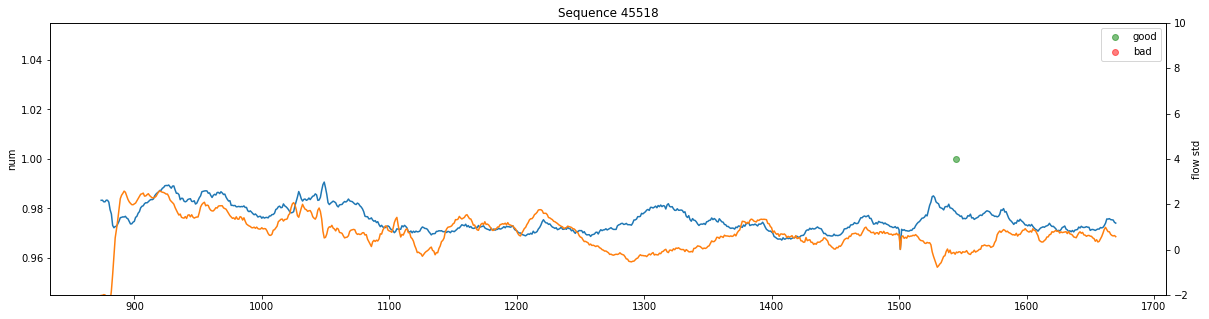

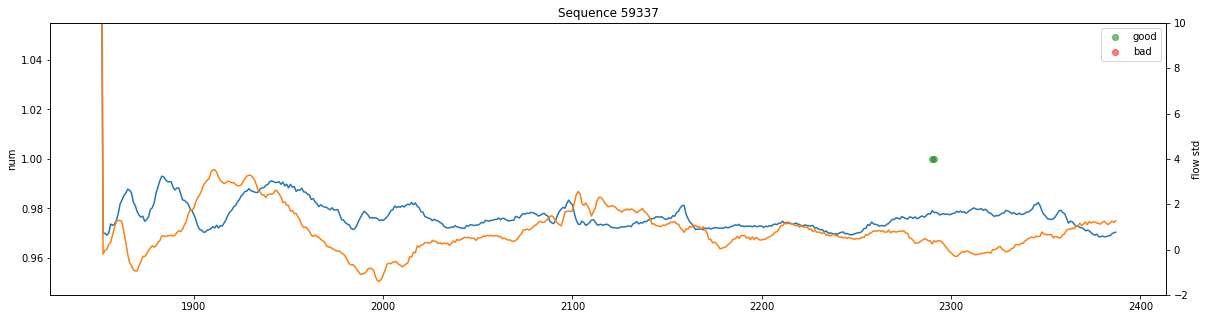

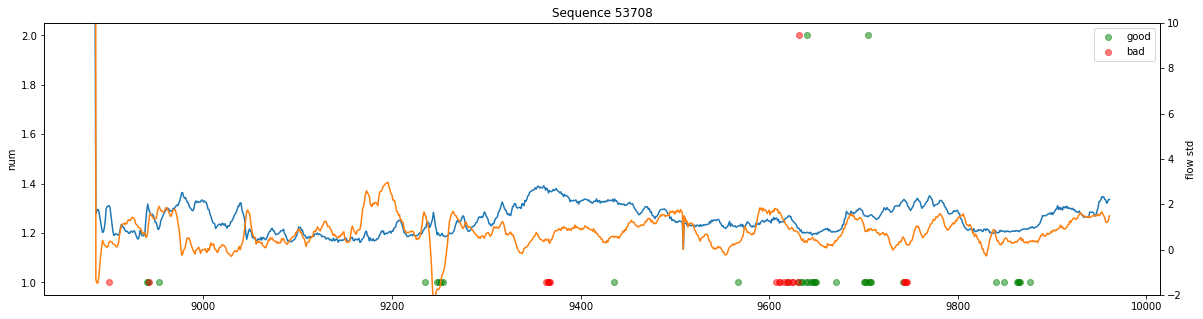

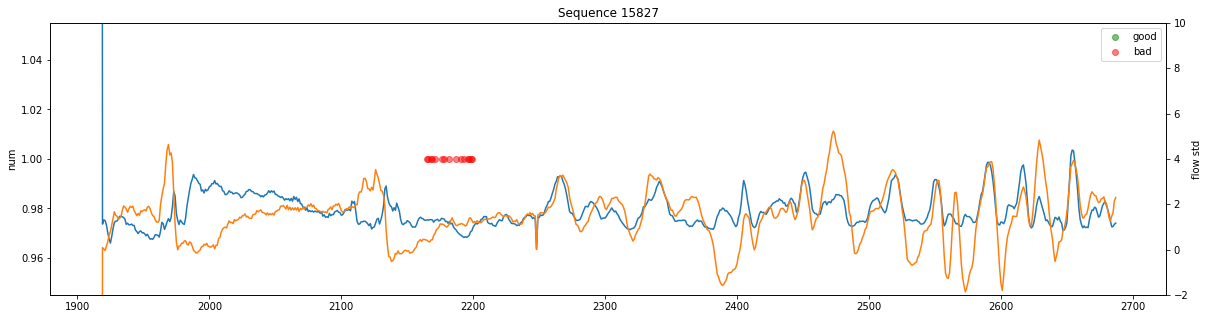

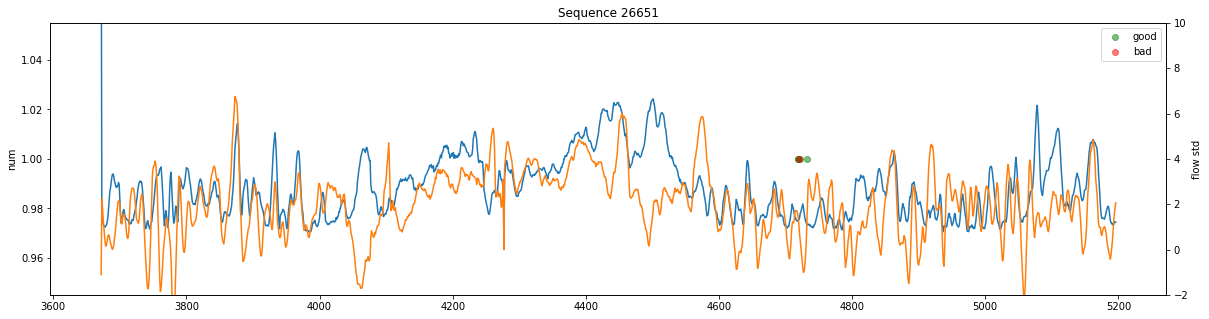

In [124]:
for seq in df_oof.query("pred_from_track_num > 0").sequence.unique():
    df_check = df_oof.query("sequence == @seq").copy().reset_index()
    #df_check['flow_std_ewm'] = df_check['flow_std'].ewm(alpha=0.9).mean()
    fig, ax1 = plt.subplots(figsize=(20,5))
    ax2 = ax1.twinx()

    #ax1.plot(df_check.video_frame, df_check.seq_change * 0.5, 'o', label='seq_change', c='black',linewidth=0.5)
    ax1.plot(df_check.video_frame, df_check.track_pred_good_num, 'o', label='good', c='g',linewidth=0.5, alpha=0.5)
    ax1.plot(df_check.video_frame, df_check.track_pred_bad_num, 'o', label='bad', c='r',linewidth=0.5, alpha=0.5)
    ax1.legend()
    ax2.plot(df_check.video_frame, df_check.flow_std, label='flow_std')
    ax2.plot(df_check.video_frame, df_check.flow_mean, label='flow_mean')
    #ax2.plot(df_check.video_frame, df_check.flow_std_ewm, 'o', label='flow_std_ewm')
    ax2.set_ylim(-2,10)
    #plt.legend()

    ax1.set_ylabel(r'num')
    ax2.set_ylabel(r'flow std')
    plt.title(f"Sequence {seq}")
    plt.show()

In [286]:
df_check.query("track_pred_bad_num >= 1")

index  video_id  sequence  video_frame  sequence_frame image_id  \
44     842         0     59337         1895              44   0-1895   
45     843         0     59337         1896              45   0-1896   
154    952         0     59337         2005             154   0-2005   
155    953         0     59337         2006             155   0-2006   
164    962         0     59337         2015             164   0-2015   
165    963         0     59337         2016             165   0-2016   
168    966         0     59337         2019             168   0-2019   
169    967         0     59337         2020             169   0-2020   
176    974         0     59337         2027             176   0-2027   
177    975         0     59337         2028             177   0-2028   
183    981         0     59337         2034             183   0-2034   
269   1067         0     59337         2120             269   0-2120   
270   1068         0     59337         2121             270   0-2121   
372   1170         0     59337         2223             372   0-2223   
373   1171         0     59337         2224             373   0-2224   
381   1179         0     59337         2232             381   0-2232   
382   1180         0     59337         2233             382   0-2233   
405   1203         0     59337         2256             405   0-2256   
429   1227         0     59337         2280             429   0-2280   
430   1228         0     59337         2281             430   0-2281   

                                           annotations  \
44   [{'x': 826, 'y': 93, 'width': 62, 'height': 47...   
45   [{'x': 839, 'y': 88, 'width': 62, 'height': 47...   
154                                                 []   
155                                                 []   
164                                                 []   
165                                                 []   
168                                                 []   
169                                                 []   
176                                                 []   
177                                                 []   
183                                                 []   
269                                                 []   
270                                                 []   
372                                                 []   
373                                                 []   
381                                                 []   
382                                                 []   
405                                                 []   
429  [{'x': 583, 'y': 233, 'width': 32, 'height': 31}]   
430  [{'x': 580, 'y': 237, 'width': 33, 'height': 31}]   

                                       new_annotations new_added_pred  \
44   [{'x': 826, 'y': 93, 'width': 62, 'height': 47...             []   
45   [{'x': 839, 'y': 88, 'width': 62, 'height': 47...             []   
154                                                 []             []   
155                                                 []             []   
164                                                 []             []   
165                                                 []             []   
168                                                 []             []   
169                                                 []             []   
176                                                 []             []   
177                                                 []             []   
183                                                 []             []   
269                                                 []             []   
270                                                 []             []   
372                                                 []             []   
373                                                 []             []   
381                                                 []             []   
382                             

In [288]:
df_check.query("video_frame >= 2000 and video_frame <= 2025")[["video_frame","real_bbox_GT","real_bbox","notrack_pred","track_pred",'pred_from_track']]

video_frame real_bbox_GT real_bbox  \
149         2000           []        []   
150         2001           []        []   
151         2002           []        []   
152         2003           []        []   
153         2004           []        []   
154         2005           []        []   
155         2006           []        []   
156         2007           []        []   
157         2008           []        []   
158         2009           []        []   
159         2010           []        []   
160         2011           []        []   
161         2012           []        []   
162         2013           []        []   
163         2014           []        []   
164         2015           []        []   
165         2016           []        []   
166         2017           []        []   
167         2018           []        []   
168         2019           []        []   
169         2020           []        []   
170         2021           []        []   
171         2022           []        []   
172         2023           []        []   
173         2024           []        []   
174         2025           []        []   

                                          notrack_pred  \
149                                                 []   
150                                                 []   
151                                                 []   
152                                                 []   
153  [[0.25496578216552734, 1078.6915254592896, 578...   
154                                                 []   
155                                                 []   
156                                                 []   
157                                                 []   
158                                                 []   
159                                                 []   
160                                                 []   
161                                                 []   
162                                                 []   
163  [[0.26041340827941895, 722.2921711206436, 422....   
164                                                 []   
165  [[0.244066521525383, 842.974029302597, 521.324...   
166  [[0.30833137035369873, 702.2333151698112, 442....   
167  [[0.33586665987968445, 832.5912932753563, 536....   
168                                                 []   
169                                                 []   
170                                                 []   
171                                                 []   
172                                                 []   
173                                                 []   
174                                                 []   

                                            track_pred  \
149                                                 []   
150                                                 []   
151                                                 []   
152                                                 []   
153                [[0.25, 1078.0, 578.0, 48.0, 37.0]]   
154                [[0.25, 1078.0, 578.0, 48.0, 37.0]]   
155                [[0.25, 1078.0, 578.0, 48.0, 37.0]]   
156                                                 []   
157                                                 []   
158                                                 []   
159                                                 []   
160                                                 []   
161                                                 []   
162                                                 []   
163                 [[0.26, 722.0, 422.0, 29.0, 22.0]]   
164                 [[0.26, 722.0, 422.0, 29.0, 22.0]]   
165  [[0.24, 842.0, 521.0, 41.0, 38.0], [0.26, 722....   
166  [[0.31, 702.0, 442.0, 29.0, 23.0], [0.25, 837....   
167  [[0.34, 832.0, 536.0, 43.0, 42.0], [0.28, 698....   
168  [[0.34, 831.0, 537.0, 43.0, 42.0], [0.28, 699....   
169                 [[0.34, 829.0, 541.0, 43.0, 42.0]]   


In [223]:
video_id = 0
sequence = 59337
s_f = 2010
e_f = 2030
make_video(df_check, video_id, sequence, 'track_pred', out_dir, 0, name="check",s_f=s_f, e_f=e_f)

video_id == 0 and sequence == 59337and video_frame >= 2010 and video_frame <= 2030
(21, 54)


OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


  0%|          | 0/21 [00:00<?, ?it/s]

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [224]:
play(out_dir + "/check.mp4")

In [52]:
# Skip_box_thr 0.16, models ['r27-0210-yolov5m6-2400', '0209_s6_B_LS02_newGT_img4096_valid', 'GT3_4680', '0207_m6_B_LS02_newGT_clahe']
# Tracking f2 0.757, precision 0.715, recall 0.768
# No Track f2 0.756, precision 0.746, recall 0.758

# Analyze Prediction

In [53]:
sizes = {}
confs = {}
for model_v in wbf_models + ['track_pred']:
    sizes[model_v] = []
    confs[model_v] = []
    
for idx,row in tqdm(df_oof.iterrows()):
    for model_v in wbf_models + ['track_pred']:
        if model_v in wbf_models:
            p = row["pred_" + model_v + "_fold1"]
            
            p = [x for x in p if (x[0] >= best_conf_dict[model_v] and x[3] * x[4] <= 15000)]
        else:
            p = row[model_v]
        if len(p) >= 1:
            sizes[model_v].extend([x[3] * x[4] for x in p])
            confs[model_v].extend([x[0] for x in p])            

0it [00:00, ?it/s]

In [54]:
gt_sizes = []
for idx,row in df_oof.iterrows():
    g = row['real_bbox']
    if len(g) >= 1:
        gt_sizes.extend([x[2] * x[3] for x in g])    

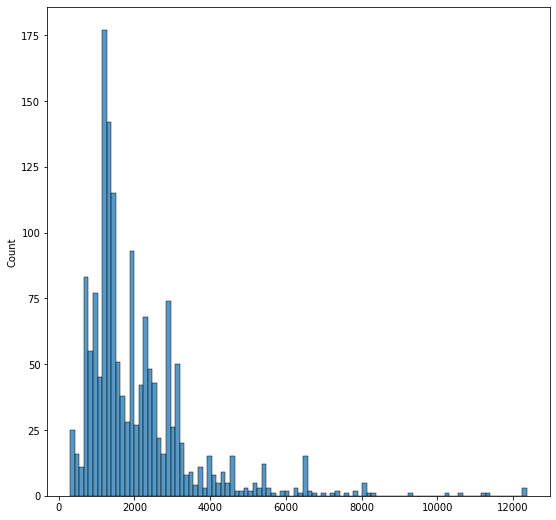

In [55]:
import seaborn as sns
plt.subplots(1,1,figsize=(9,9))
sns.histplot(gt_sizes, bins=100)
plt.show()

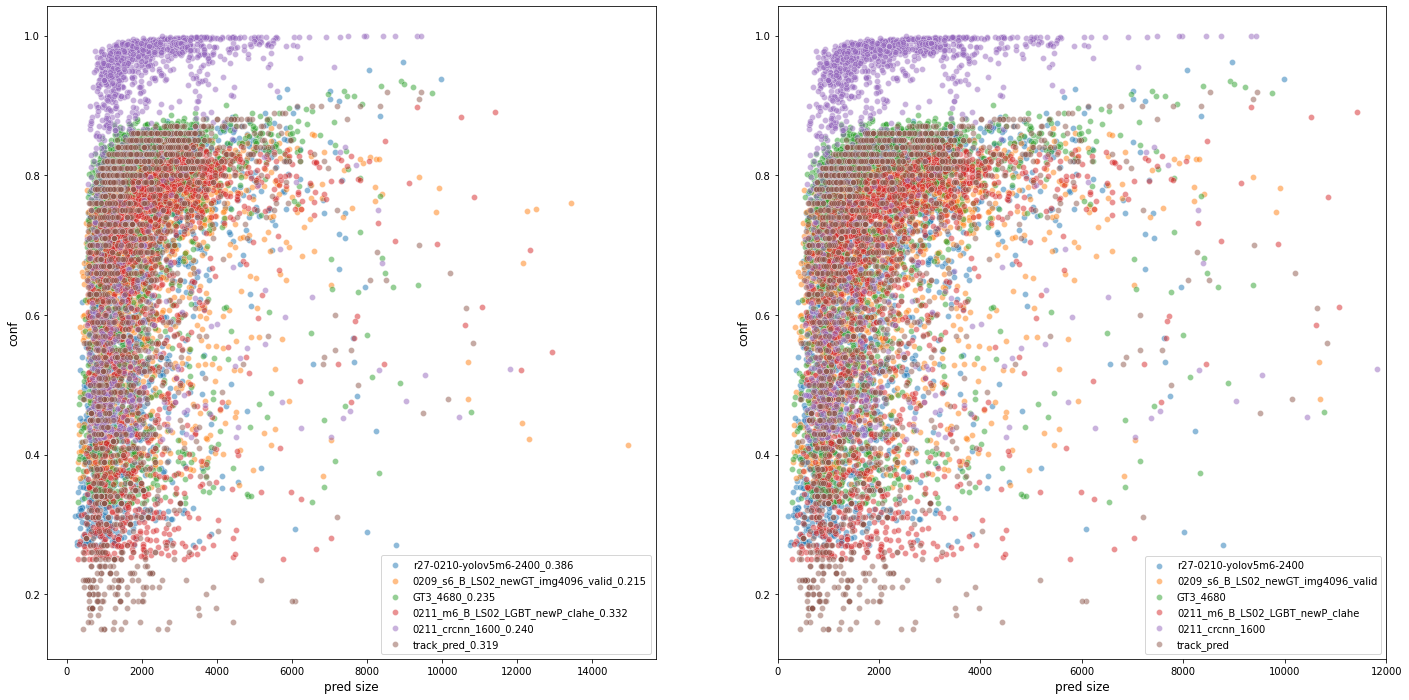

In [59]:
fig, axes = plt.subplots(1,2,figsize=(24,12))

for model_v in wbf_models + ['track_pred']:
    corr  = np.corrcoef(confs[model_v], sizes[model_v])[0,1]
    sns.scatterplot(x=sizes[model_v], y=confs[model_v], label=model_v + "_{:.3f}".format(corr), alpha=0.5, ax=axes[0])
    
axes[0].legend()
axes[0].set_xlabel("pred size", size=12)
axes[0].set_ylabel("conf", size=12)

for model_v in wbf_models + ['track_pred']:
    sns.scatterplot(x=sizes[model_v], y=confs[model_v], label=model_v, alpha=0.5, ax=axes[1])
    
axes[1].legend()
axes[1].set_xlabel("pred size", size=12)
axes[1].set_ylabel("conf", size=12)
axes[1].set_xlim(0, 12000)
plt.show()

In [ ]:
# basic_cols = ['video_id', 'sequence', 'video_frame', 'sequence_frame', 'image_id',
#        'annotations', 'fold', 'old_image_path', 'image_path', 'label_path',
#        'real_bbox', 'num_bbox']
# basic_cols = basic_cols + ['notrack_pred']
# util.save_pickle(df_oof[basic_cols],"../input/wbf_notrack_pred.pkl")

# check image

In [ ]:
check_versions = ["wbf"]
f2_score_df.loc[check_versions[:-1]].style.format("{:.3f}").background_gradient(axis=0)

In [ ]:
df_oof['tp'] = 0
df_oof['fp'] = 0
df_oof['fn'] = 0
for key in check_versions: 
    df_oof[f'{key}_tp'] = df_oof[f'{key}_tps'].apply(np.sum)
    df_oof[f'{key}_fp'] = df_oof[f'{key}_fps'].apply(np.sum)
    df_oof[f'{key}_fn'] = df_oof[f'{key}_fns'].apply(np.sum)
    df_oof['tp'] = df_oof['tp'] + df_oof[f'{key}_tp']
    df_oof['fp'] = df_oof['fp'] + df_oof[f'{key}_fp']
    df_oof['fn'] = df_oof['fn'] + df_oof[f'{key}_fn']

In [ ]:
color_pred = [(0,125,0)]    
color_real = [(255,0,0)]
def plot_img(df, idx, keys, save=False, pre=""):
    row = df.iloc[idx]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    real_bboxes = row["real_bbox"]
    preds = row["track_pred"]
#     for key in keys:
#         best_conf = best_conf_dict[key]
#         pred_col = "pred_" + key + "_fold1"
#         if len(row[pred_col]) > 0:
#             preds = preds + [p for p in row[pred_col] if p[0] >= best_conf]
            
    bboxes = [p[1:5] for p in preds]
    confis = [p[0] for p in preds]
    print(f"video {row.video_id}, sequence {row.sequence}, frame {row.video_frame}")
    img_plot = util.show_img(img, 
                          bboxes + real_bboxes, 
                          confis + [1] * len(real_bboxes),
                          color_pred  * len(bboxes) + color_real * len(real_bboxes), 
                          bbox_format='coco')
    if save:
        img_plot.save(f"./pic_check/{pre}v{row.video_id}_frame{row.video_frame}_seq{row.sequence}.jpg")
    display(img_plot)

In [ ]:
for i, iou in tqdm(enumerate(np.arange(0.3,0.85,0.05))):
    df_oof[f"f2_{iou:.2f}"] = 0
    df_oof[f"P_{iou:.2f}"] = 0
    df_oof[f"R_{iou:.2f}"] = 0
    for idx in df_oof.index:
        tp = 0
        fp = 0
        fn = 0
        for key in check_versions:
            tp += df_oof.loc[idx, f'{key}_tps'][i]
            fp += df_oof.loc[idx, f'{key}_fps'][i]
            fn += df_oof.loc[idx, f'{key}_fns'][i]
        df_oof.loc[idx, f"f2_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=2)
        df_oof.loc[idx, f"P_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=0)
        df_oof.loc[idx, f"R_{iou:.2f}"] = util.f_beta(tp, fp, fn, beta=100)

In [ ]:
df_oof["f2"] = df_oof[[f'f2_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
df_oof["P"] = df_oof[[f'P_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
df_oof["R"] = df_oof[[f'R_{iou:.2f}' for iou in np.arange(0.3,0.85,0.5)]].mean(axis=1)
#df_oof.head()

In [ ]:
show_col = ["video_id","sequence","video_frame","num_bbox", "f2", "P", "R"]
sub_col = ["fp"] + [key+"_fp" for key in check_versions]
sub_col = sub_col + ["tp"] + [key+"_tp" for key in check_versions]
sub_col = sub_col + ["fn"] + [key+"_fn" for key in check_versions]

## most FP among empy group

In [ ]:
df_neg = df_oof.query("num_bbox == 0").copy()
df_neg.sort_values("fp", ascending=False, inplace=True)
df_neg.reset_index(inplace=True, drop=True)
df_neg[show_col + sub_col].head()

In [ ]:
for i in range(5):
    plot_img(df_neg, i, model_versions, save=False)

## Most FP among non-empty group

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("fp", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head()

In [ ]:
for i in range(5):
    plot_img(df_pos, i, model_versions)

## Most TP

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("tp", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head(5)

In [ ]:
for i in range(3):
    plot_img(df_pos, i, model_versions)

## Most FN

In [ ]:
df_pos = df_oof.query("num_bbox > 0").copy()
df_pos.sort_values("fn", ascending=False, inplace=True)
df_pos.reset_index(inplace=True, drop=True)
df_pos[show_col + sub_col].head(10)

In [ ]:
for i in range(10):
    plot_img(df_pos, i, model_versions)

# Make Video

In [ ]:
df_oof.groupby(["video_id","sequence"]).size()

In [ ]:
for video_id, sequence in df_oof.groupby(["video_id","sequence"]).size().index:
    name = f'wbf-{video_id}-{sequence}'
    make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name)

In [ ]:
video_id = 1
sequence = 15827
s_f = 2148
e_f = 2205
q = f"video_id == {video_id} and sequence == {sequence} and video_frame >= {s_f} and video_frame <= {e_f}"
df_oof_check = df_oof.reset_index(drop=True).query(q).copy()

In [ ]:
df_oof_check.index

In [ ]:
f2_dict = util.calc_f2_score(gt_bboxs_list, prd_wbf_list, verbose=False) 
f2_dict['f2']

In [ ]:
gt_bboxs_list_modify = gt_bboxs_list.copy()
prd_wbf_list_modify = prd_wbf_list.copy()

In [ ]:
# for idx in df_oof_check.index:
#     prd_wbf_list_modify[idx] = np.array([])
for idx in df_oof_check.index:
    pred = prd_wbf_list_modify[idx]
    if len(pred) > 0:
        gt_bboxs_list_modify[idx] = pred[:,1:]

In [ ]:
# for idx in df_oof_check.index:
#     print(gt_bboxs_list_modify[idx])

In [ ]:
prd_wbf_list_modify[idx]

In [ ]:
f2_dict = util.calc_f2_score(gt_bboxs_list_modify, prd_wbf_list_modify, verbose=False) 
f2_dict['f2']

In [ ]:
(df_oof_check['track_pred'].apply(len) > 0).sum()

In [ ]:
video_id = 2
sequence =26651
s_f =4154
e_f =4200

name = f'UnkownFP_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
df_oof['track_pred']

In [ ]:
video_id = 2
sequence =26651
s_f =4639
e_f =4748

name = f'FP_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
video_id = 2
sequence =26651
s_f =5024
e_f =5090

name = f'Fish_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

In [ ]:
video_id = 2
sequence =26651
s_f =5120
e_f =5160

name = f'Fish_wbf-{video_id}-{sequence}-{s_f}-{e_f}'
make_video(df_oof, video_id, sequence, 'track_pred', out_dir, 0, name=name,s_f=s_f, e_f=e_f)

# Improve FN

In [ ]:
egs = [
    # sequence , frame id
    (53708, 8926),
    (53708, 8928),
    (53708, 9654),
    (53708, 9655),
]

In [ ]:

def plot_img_2(df, sequence, frame_id, keys, save=False, pre="", use_clahe=False, aug=None):
    #row = df.iloc[idx]
    row = df.query("sequence == @seq and video_frame == @frame_id").iloc[0]
    path = row["image_path"]
    img = cv2.imread(str(path))[...,::-1]
    if use_clahe:
        for i in range(3):
            img[:, :, i] = clahe.apply((img[:, :, i]))         
    if aug is not None:
        img = aug(image=img)['image']
    real_bboxes = row["real_bbox"]
    preds = row["track_pred"]            
    bboxes = [p[1:5] for p in preds]
    confis = [p[0] for p in preds]
    print(f"video {row.video_id}, sequence {row.sequence}, frame {row.video_frame}")
    img_plot = util.show_img(img, 
                          bboxes + real_bboxes, 
                          confis + [1] * len(real_bboxes),
                          color_pred  * len(bboxes) + color_real * len(real_bboxes), 
                          bbox_format='coco')
    if save:
        img_plot.save(f"./pic_check/{pre}v{row.video_id}_frame{row.video_frame}_seq{row.sequence}.jpg")
    display(img_plot)

In [ ]:
seq, frame = egs[0]
seq_tp = 53708
frame_tp = 9653
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False)

## CLAHE

In [ ]:
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(10, 10))
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=True)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=True)        

## HueSaturationValue

In [ ]:
aug = A.HueSaturationValue(hue_shift_limit=10,p = 1.0)
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False, aug=aug)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False, aug=aug)        

## RGBShift

In [ ]:
aug = A.RGBShift(r_shift_limit = 40, b_shift_limit=0, g_shift_limit=0, p = 1.0)
plot_img_2(df_oof, seq, frame, model_versions, use_clahe=False, aug=aug)
plot_img_2(df_oof, seq_tp, frame_tp, model_versions, use_clahe=False, aug=aug)        

## FUnIE-GAN

In [ ]:
sys.path.append("./FUnIE-GAN/PyTorch/")
from nets import funiegan

model_path = "./FUnIE-GAN/PyTorch/models/funie_generator.pth"
model = funiegan.GeneratorFunieGAN()
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

In [ ]:
model.eval()

In [ ]:
import torchvision.transforms as transforms
## data pipeline
img_width, img_height, channels = 1280, 1280, 3
transforms_ = [transforms.Resize((img_height, img_width), transforms.InterpolationMode.BICUBIC),
               transforms.ToTensor(),
               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]
transform = transforms.Compose(transforms_)

In [ ]:
path = df_oof.query("sequence == 53708 and video_frame == 8926").iloc[0]["image_path"]
path = df_oof.query("sequence == 53708 and video_frame == 9653").iloc[0]["image_path"]

In [ ]:
from PIL import Image
from torch.autograd import Variable
import torch
Tensor = torch.FloatTensor 
#path = '../../data/tensorflow-great-barrier-reef/train_images/video_0/8926.jpg'
inp_img = transform(Image.open(path))
inp_img = Variable(inp_img).type(Tensor).unsqueeze(0)
gen_img = model(inp_img)

In [ ]:
from torchvision.utils import save_image

In [ ]:
save_image(gen_img, "./test2.jpg", normalize=True)

In [ ]:
plt.imshow(gen_img.squeeze().data.permute(1, 2, 0).numpy())